In [0]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
!pip install mxnet-cu101
!pip install gluoncv

08. Finetune a pretrained detection model
============================================

Fine-tuning is commonly used approach to transfer previously trained model to a new dataset.
It is especially useful if the targeting new dataset is relatively small.

Finetuning from pre-trained models can help reduce the risk of overfitting.
Finetuned model may also generalizes better if the previously used dataset is in the similar domain of the new dataset.

This tutorial opens up a good approach for fine-tuning object detection models
provided by GluonCV.
More Specifically, we show how to use a customized Pikachu dataset and illustrate the finetuning fundamentals step by step.
You will be familiarize the steps and modify it to fit your own object detection projects.


In [0]:
import os, zipfile
import time
import json
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
from gluoncv import utils
import gluoncv as gcv
from gluoncv.utils import download, viz
from skimage import io
import cv2
from tqdm import tqdm
import glob
from mxnet import nd
from gluoncv.data import LstDetection

 OXFORD TOWN CENTRE Dataset
----------------
First we will start with a nice Pikachu dataset generated by rendering 3D models on random real-world scenes.
You can refer to `sphx_glr_build_examples_datasets_detection_custom.py` for tutorial of how to create your own datasets.



In [0]:
video = utils.download('https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi', path='./')

100%|██████████| 144030/144030 [00:05<00:00, 26811.82KB/s]


In [0]:
gt = utils.download('https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentre-groundtruth.top', path = './')

5424KB [00:00, 6750.52KB/s]                          


In [0]:
class Video2ImageSequence:
    def __init__(self, interval = None):
        self.interval = interval

    def __call__(self, video_path, image_save_path, start = 0, end = None):
        v_cap = cv2.VideoCapture(video)
        fps = v_cap.get(cv2.CAP_PROP_FPS)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        end = v_len if end is None else end
        if self.interval is None:
            sampler = np.arange(start, end, int(fps))
        else:
            ampler = np.arange(start, end, interval)

        if not os.path.exists(image_save_path):
            os.mkdir(image_save_path)

        for i in tqdm(range(v_len)):
            success = v_cap.grab()
            if i in sampler:
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                cv2.imwrite(f'{image_save_path}/{i}.png', frame)
        v_cap.release()

In [0]:
def Top2Dict(path):
    all_dets = np.loadtxt(path ,delimiter=',')
    frame_num = all_dets[:, 1].astype(int)
    rst = {}
    for i in sorted(set(frame_num)):
        rst[i] = all_dets[frame_num == i][:,-4:]
    return rst
gtboxes = Top2Dict('./TownCentre-groundtruth.top')

In [0]:
class GroundTruth:
    def __init__(self, images_path, gtboxes, classes = ['person']):
        self.images = sorted(glob.glob(f'{images_path}/*'), key = lambda x: int(x.split('/')[-1].split('.')[0]))
        self.gtboxes = gtboxes
        self.classes = classes

    def imshow(self, index):
        path, gtboxes = self[index]
        img = io.imread(path)
        ax = viz.plot_bbox(img, bboxes=gtboxes, labels = np.zeros(len(gtboxes)), class_names=self.classes)
        plt.show()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        num = int(self.images[index].split('/')[-1].split('.')[0])
        return self.images[index], self.gtboxes[num]

    def _write_line(self, img_path, im_shape, boxes, ids, idx):
        h, w, c = im_shape
        # for header, we use minimal length 2, plus width and height
        # with A: 4, B: 5, C: width, D: height
        A = 4
        B = 5
        C = w
        D = h
        # concat id and bboxes
        labels = np.hstack((ids.reshape(-1, 1), boxes)).astype('float')
        # normalized bboxes (recommanded)
        labels[:, (1, 3)] /= float(w)
        labels[:, (2, 4)] /= float(h)
        # flatten
        labels = labels.flatten().tolist()
        str_idx = [str(idx)]
        str_header = [str(x) for x in [A, B, C, D]]
        str_labels = [str(x) for x in labels]
        str_path = [img_path]
        line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'
        return line

    def generate_lst_file(self, filename, filepath = './'):
        img_shape = None
        with open(f'{filepath}/{filename}.lst', 'w') as fw:
            for i in tqdm(range(len(self))):
                img_path, gtboxes = self[i]
                if img_shape is None:
                    img_shape = io.imread(img_path).shape
                line = self._write_line(img_path, img_shape, gtboxes, np.zeros(len(gtboxes)), i)
                # print(line)
                fw.write(line)

In [0]:
images_generator = Video2ImageSequence()

images_generator('./TownCentreXVID.avi', './TrainImages', end = 3501)
train_gt = GroundTruth('./TrainImages', gtboxes)
train_gt.generate_lst_file('train')

images_generator('./TownCentreXVID.avi', './ValImages', start = 3501, end = 4501)
gtboxes = Top2Dict('./TownCentre-groundtruth.top')
val_gt = GroundTruth('./ValImages', gtboxes)
val_gt.generate_lst_file('val')

100%|██████████| 40/40 [00:00<00:00, 571.25it/s]


We can load dataset using ``RecordFileDetection``



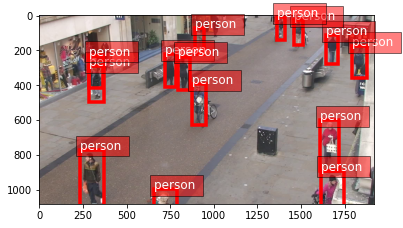

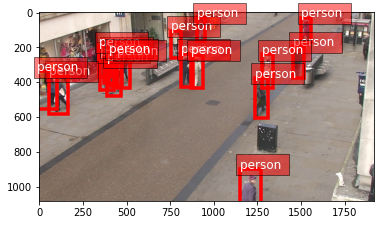

In [0]:
# train_gt.imshow(0)
# val_gt.imshow(0)

In [0]:
# train_gt[0], train_gt[-1], val_gt[0], val_gt[-1]

### Split train and validation set(8:2)

In [0]:
from gluoncv.data import LstDetection
train_lst_dataset = LstDetection('train.lst')
val_lst_dataset = LstDetection('val.lst')

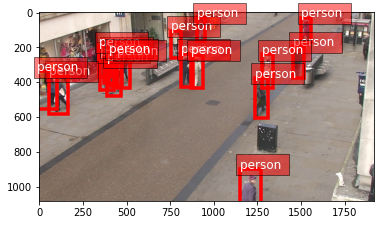

In [0]:
ax = viz.plot_bbox(train_lst_dataset[0][-1], bboxes=train_lst_dataset[0][1][:, :4], labels = train_lst_dataset[0][1][:, 4:], class_names=train_gt.classes)
plt.show()
ax = viz.plot_bbox(val_lst_dataset[0][0], bboxes=val_lst_dataset[0][1][:, :4], labels = val_lst_dataset[0][1][:, 4:], class_names=val_gt.classes)
plt.show()

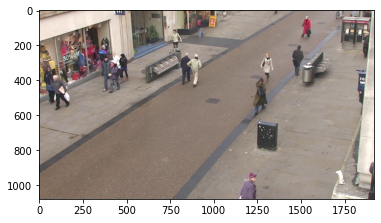

In [0]:
plt.imshow(val_lst_dataset[0][0].asnumpy())
plt.show()

CalTech
-------------------

In [0]:
caltech_datapath = './drive/My Drive/SocialDistance/data/Caltech'
print(glob.glob(f'{caltech_datapath}/*'))

['./drive/My Drive/SocialDistance/data/Caltech/set10', './drive/My Drive/SocialDistance/data/Caltech/set07', './drive/My Drive/SocialDistance/data/Caltech/set08', './drive/My Drive/SocialDistance/data/Caltech/set00', './drive/My Drive/SocialDistance/data/Caltech/set02', './drive/My Drive/SocialDistance/data/Caltech/set01', './drive/My Drive/SocialDistance/data/Caltech/set06', './drive/My Drive/SocialDistance/data/Caltech/set03', './drive/My Drive/SocialDistance/data/Caltech/set05', './drive/My Drive/SocialDistance/data/Caltech/set09', './drive/My Drive/SocialDistance/data/Caltech/set04', './drive/My Drive/SocialDistance/data/Caltech/annotations.json', './drive/My Drive/SocialDistance/data/Caltech/Caltech_train.lst', './drive/My Drive/SocialDistance/data/Caltech/Caltech_val.lst']


In [0]:
class GroundTruth_Caltech:
    def __init__(self, caltech_datapath, annotation, start = 0, end = 0, classes = ['person']):
        all_files = sorted(glob.glob(f'{caltech_datapath}/*'), key = lambda x: x.split('/')[-1])
        end = len(all_files) if end == 0 else end
        self.sets = list(filter(lambda x:os.path.isdir(x), all_files))[start:end]
        json_file = open(annotation) 
        self.annotation = json.load(json_file)
        self.classes = classes

    def imshow(self, index):
        video_path, sets_number = self[i]
        video_number = os.path.basename(video_path)
        for f in sorted(glob.glob(f'{video_path}/*')):
          f_number = os.path.basename(f)
          gt = self.annotation[sets_number][video_number]['frames'][f_number]


        # img = io.imread(path)
        # ax = viz.plot_bbox(img, bboxes=gtboxes, labels = np.zeros(len(gtboxes)), class_names=self.classes)
        # plt.show()

    def __len__(self):
        return len(self.sets)

    def __getitem__(self, index):
        return sorted(glob.glob(f'{self.sets[index]}/*')), os.path.basename(self.sets[index])

    def _write_line(self, img_path, im_shape, boxes, ids, idx):
        h, w, c = im_shape
        # for header, we use minimal length 2, plus width and height
        # with A: 4, B: 5, C: width, D: height
        A = 4
        B = 5
        C = w
        D = h
        # concat id and bboxes
        labels = np.hstack((ids.reshape(-1, 1), boxes)).astype('float')
        # normalized bboxes (recommanded)
        labels[:, (1, 3)] /= float(w)
        labels[:, (2, 4)] /= float(h)
        # flatten
        labels = labels.flatten().tolist()
        str_idx = [str(idx)]
        str_header = [str(x) for x in [A, B, C, D]]
        str_labels = [str(x) for x in labels]
        str_path = [img_path]
        line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'
        return line

    def generate_lst_file(self, filename, filepath = './'):
        img_shape = None
        with open(f'{filepath}/{filename}.lst', 'w') as fw:
            for i in tqdm(range(len(self))):
                video_path, sets_number = self[i]
                for v in video_path:
                  video_number = os.path.basename(v)
                  for f in sorted(glob.glob(f'{v}/*')):
                    f_number = os.path.basename(f).split('.')[0]
                    if img_shape is None:
                        img_shape = io.imread(f).shape
                    # print(sets_number, video_number, f_number)
                    gt = self.annotation[sets_number][video_number]['frames'][f_number]
                    # print('gt is ',gt)
                    gt_box = []
                    for g in gt:
                      gt_box.append([g['pos'][0], g['pos'][1], g['pos'][0]+g['pos'][2], g['pos'][1]+g['pos'][3]])
                    gt_box = np.array(gt_box)
                    line = self._write_line(f, img_shape, gt_box, np.zeros(len(gt_box)), i)
                    # print(line)
                    fw.write(line)

In [0]:
caltech_datapath = './drive/My Drive/SocialDistance/data/Caltech'
annotation = './drive/My Drive/SocialDistance/data/Caltech/annotations.json'
train_gt = GroundTruth_Caltech(caltech_datapath, annotation, start = 0, end = 6)
train_gt.generate_lst_file(caltech_datapath + '/Caltech_train')

# images_generator('./TownCentreXVID.avi', './ValImages', start = 3501, end = 4501)
# gtboxes = Top2Dict('./TownCentre-groundtruth.top')
val_gt = GroundTruth_Caltech(caltech_datapath, annotation, start = 6,end = 11)
train_gt.generate_lst_file(caltech_datapath + '/Caltech_val')

100%|██████████| 6/6 [00:00<00:00, 26.60it/s]


In [0]:

train_lst_dataset = LstDetection(caltech_datapath + '/Caltech_train.lst')
val_lst_dataset = LstDetection(caltech_datapath + '/Caltech_val.lst')

In [0]:
print('length:', len(train_lst_dataset))
first_img = train_lst_dataset[0][0]
print('image shape:', first_img.shape)
print('Label example:')
print(train_lst_dataset[0][1])
print("GluonCV swaps bounding boxes to columns 0-3 by default")

length: 2699
image shape: (480, 640, 3)
Label example:
[[227.18601258 133.78248658 233.31897918 146.047431     0.        ]]
GluonCV swaps bounding boxes to columns 0-3 by default


Oxford + Mall
-------------

In [0]:
print('length:', len(train_lst_dataset))
first_img = train_lst_dataset[0][0]
print('image shape:', first_img.shape)
print('Label example:')
print(train_lst_dataset[0][1])
print("GluonCV swaps bounding boxes to columns 0-3 by default")

length: 214
image shape: (480, 640, 3)
Label example:
[[496. 316. 548. 463.   0.]
 [198. 215. 230. 265.   0.]
 [113. 359. 159. 482.   0.]
 [374. 298. 416. 413.   0.]
 [  3. 204.  34. 319.   0.]
 [ 45. 220.  74. 318.   0.]
 [124. 229. 160. 331.   0.]
 [135. 186. 170. 273.   0.]
 [229. 214. 264. 263.   0.]
 [347. 428. 417. 480.   0.]
 [553. 286. 590. 413.   0.]
 [296. 443. 353. 480.   0.]
 [312. 240. 348. 351.   0.]
 [344. 244. 387. 322.   0.]
 [510. 114. 527. 193.   0.]
 [523. 108. 548. 181.   0.]
 [546. 128. 582. 217.   0.]
 [121.  96. 146. 137.   0.]
 [164.  67. 184. 125.   0.]
 [184.  60. 199. 123.   0.]
 [117.  52. 139.  96.   0.]]
GluonCV swaps bounding boxes to columns 0-3 by default


Pre-trained models
-------------------
Now we can grab a pre-trained model to finetune from. Here we have so many choices from `gluoncv-model-zoo-detection` Model Zoo.
Again for demo purpose, we choose a fast SSD network with MobileNet1.0 backbone.



There is a convenient API for creating custom network with pre-trained weights.
This is equivalent to loading pre-trained model and call ``net.reset_class``.




In [0]:
net = gcv.model_zoo.get_model('ssd_512_resnet50_v1_custom', classes=['person'],
    pretrained_base=False, transfer='voc')

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:1389: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


100%|██████████| 132723/132723 [00:03<00:00, 44202.01KB/s]


In [0]:
net = gcv.model_zoo.get_model('yolo3_darknet53_custom', classes=train_gt.classes,
    pretrained_base=False, transfer='voc')

223070KB [11:27, 324.37KB/s]                             


By loading from fully pre-trained models, you are not only loading base network weights
(mobilenet for example), but also some additional blocks for object detection specifically.

Pretrained model from detection task is more relevant and adaptive than ``pretrained_base``
network which is usually trained on ImageNet for image classification task.

Therefore finetuning may converge significantly faster and better in some situations.



Finetuning is a new round of training
--------------------------------------
.. hint::

    You will find a more detailed training implementation of SSD here:
    :download:`Download train_ssd.py<../../../scripts/detection/ssd/train_ssd.py>`



In [0]:
def get_width_height(img_shape, short_side = 512):
    short = min(img_shape)
    height, weight = img_shape[0]*(short_side/short), img_shape[1]*(short_side/short)
    return int(weight), int(height)

width, height = get_width_height(io.imread(train_gt[0][0]).shape[:2])
print(width, height)

910 512


#### Train loader

In [0]:
class Unnormalize:
    '''
    Converts an image tensor to previously Normalized
    back to an image with pixels in the range [0, 1]
    '''
    def __init__(self, mean, std):
        self.mean = nd.array(mean)
        self.std = nd.array(std)

    def __call__(self, tensor):
        tensor = tensor.transpose((1, 2, 0))
        mean = self.mean
        std = self.mean
        return nd.clip(tensor*std + mean, 0., 1.)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
unnormalize_transform = Unnormalize(mean, std)

(3, (3, 480, 640), (7232,), (7232, 4))

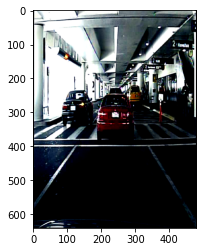

##### Val loader

In [0]:
v = iter(val_loader)
batch = next(v)

In [0]:
len(batch), batch[0][0].shape, batch[1][0].shape

(2, (3, 512, 910), (19, 5))

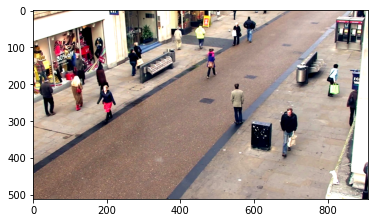

In [0]:
plt.imshow(unnormalize_transform(batch[0][0]).asnumpy())
plt.show()

Try use GPU for training
------------------------



In [0]:
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
except:
    ctx = [mx.cpu()]
ctx

[gpu(0)]

SSD
---

Start training(finetuning)



In [0]:
def get_dataloader(net, train_dataset, val_dataset, width, height, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform, SSDDefaultValTransform

    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
    
    
    train_batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=train_batchify_fn, last_batch='rollover', num_workers=num_workers)
    
    val__batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
    val_loader = gluon.data.DataLoader(
        val_dataset.transform(SSDDefaultValTransform(width, height)),
        batch_size, True, batchify_fn=val__batchify_fn, last_batch='rollover', num_workers=num_workers) 
    
    return train_loader, val_loader

train_loader, val_loader = get_dataloader(net, train_lst_dataset, val_lst_dataset, width, height,6, 0)


In [0]:
# t = iter(train_loader)
# batch = next(t)
# print(len(batch), batch[0][0].shape, batch[1][0].shape, batch[2][0].shape)
# plt.imshow(unnormalize_transform(batch[0][2]).asnumpy())
# plt.show()

In [0]:
from collections import defaultdict
from gluoncv.utils import bbox_iou
class RepulsionLoss(gluon.Block):
  def __init__(self, iou_thresh = 0.5, sigma = 0.5, epo = 0.1, **kwargs):
    super(RepulsionLoss, self).__init__(**kwargs)
    self.iou_thresh = iou_thresh
    self.sigma = sigma
    self.epo = epo
  def Smooth_Ln(self, x, sigma):
    large = np.where(x > sigma)
    small = np.where(x <= sigma)

    large = x[large]
    small = x[small]

    large = np.sum((large-sigma)/(1-sigma) - np.log(1-sigma))
    small = np.sum(-np.log(1-small))

    return (large + small)
  def forward(self, cls_preds, box_preds, cls_targets, box_targets, loss = None):
    RepLoss = []
    all_box_gt = box_targets[0].asnumpy()
    all_box_pred = box_preds[0].asnumpy()
    # print(all_box_gt.shape, box_pred.shape)
    for i in range(all_box_pred.shape[0]):
      #filter out all zero rows(mainly gt)
      nonzero_boxgt_index = np.where(all_box_gt[i][:,0] != all_box_gt[i][:,2])
      nonzero_boxpred_index = np.where(all_box_pred[i][:,0] != all_box_pred[i][:,2])

      nonzero_box_gt = all_box_gt[i][nonzero_boxgt_index][:,0:4]
      nonzero_box_pred = all_box_pred[i][nonzero_boxpred_index][:,0:4]

      #calculate iou
      _iou = bbox_iou(nonzero_box_pred, nonzero_box_gt)

      # select positive proposals
      pos_index = np.where(np.max(_iou, axis=1) >= self.iou_thresh)
      _iou = _iou[pos_index]
      # print('iou shape ', _iou.shape)
      #for each positive proposals keep its top two iou with targets
      sort_index = _iou.argsort(axis = 1)[:,-2:]
      iog = []
      for _i in range(len(sort_index)):
        tmp = _iou[_i, sort_index[_i]]
        iog.append(tmp)
      iog = np.array(iog)
      # print('iog first and second',iog.shape)
      # print()
      if iog.shape[0] == 0:
        RepGT = 0
        RepBo = 0
      else:
        #RepulsionGT
        RepGT = self.Smooth_Ln(iog[:,0], self.sigma)/iog.shape[0]
        #for each ground truth keep only the proposal with highest iou
        pos_gt_prop_index = np.argmax(_iou, axis=0)
        pos_gt_prop = np.array([nonzero_box_pred[pos_gt_prop_index], nonzero_box_pred[pos_gt_prop_index]])
        # RepulsionBox
        box_l = np.array([])
        total_iou = np.array([])
        for row in range(len(pos_gt_prop[0])-1):
          curr = pos_gt_prop[0][row].reshape(1,-1)
          rest = pos_gt_prop[1][row+1:]
          _bbox_iou = bbox_iou(curr, rest)
          box_l = np.hstack((box_l, [self.Smooth_Ln(_bbox_iou, self.sigma)]))
          total_iou = np.hstack((total_iou, [np.sum(_bbox_iou)]))
        RepBo = np.sum(box_l) / (np.sum(total_iou) + self.epo)
          # print('loss',Smooth_Ln(_bbox_iou, sigma), RepBo)
      RepLoss.append(RepGT + RepBo)
    RepLoss = [nd.array(RepLoss, ctx=mx.gpu(0))]
    if loss:
      sum_loss, cls_loss, box_loss = loss(cls_preds, box_preds, cls_targets, box_targets)#TODO:YOLO-VERSION
      return nd.add(RepLoss[0], sum_loss[0]), cls_loss, box_loss
    else:
      return RepLoss, 0,0

In [0]:
from gluoncv.utils.metrics.voc_detection import VOC07MApMetric
def validate(net, val_data, ctx, eval_metric):
    """Test on validation dataset."""
    eval_metric.reset()
    # set nms threshold and topk constraint
    net.set_nms(nms_thresh=0.45, nms_topk=400)
    net.hybridize(static_alloc=True, static_shape=True)
    for batch in val_data:
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        det_bboxes = []
        det_ids = []
        det_scores = []
        gt_bboxes = []
        gt_ids = []
        gt_difficults = []
        for x, y in zip(data, label):
            # get prediction results
            ids, scores, bboxes = net(x)
            det_ids.append(ids)
            det_scores.append(scores)
            # clip to image size
            det_bboxes.append(bboxes.clip(0, batch[0].shape[2]))
            # split ground truths
            gt_ids.append(y.slice_axis(axis=-1, begin=4, end=5))
            gt_bboxes.append(y.slice_axis(axis=-1, begin=0, end=4))
            gt_difficults.append(y.slice_axis(axis=-1, begin=5, end=6) if y.shape[-1] > 5 else None)

        # update metric
        eval_metric.update(det_bboxes, det_ids, det_scores, gt_bboxes, gt_ids, gt_difficults)
    return eval_metric.get()
eval_metric = VOC07MApMetric(iou_thresh=0.5, class_names=['person'])

In [0]:
maps = []
def train(net, train_loader, val_loader, eval_metric, ctx, epochs = 10, save_path = './', optimizer_parameter = {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9}, seed = 0):
    utils.random.seed(seed)
    net.collect_params().reset_ctx(ctx)
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': optimizer_parameter['learning_rate'], 'wd': optimizer_parameter['wd'], 'momentum': optimizer_parameter['momentum']})
    mbox_loss = gcv.loss.SSDMultiBoxLoss(lambd = 0.5)
    Repulsion = RepulsionLoss()#
    ce_metric = mx.metric.Loss('CrossEntropy')
    smoothl1_metric = mx.metric.Loss('SmoothL1')

    best_mean_ap = float('-inf')
    for epoch in range(epochs):
        ce_metric.reset()
        smoothl1_metric.reset()
        tic = time.time()
        btic = time.time()
        # print(epochs, optimizer_parameter['lr_decay_step'], epoch % optimizer_parameter['lr_decay_step'] == 0)
        if 'lr_decay' in optimizer_parameter and 'lr_decay_step' in optimizer_parameter\
        and epoch != 0 and epoch % optimizer_parameter['lr_decay_step'] == 0:
            old_lr = trainer.learning_rate
            new_lr = trainer.learning_rate * optimizer_parameter['lr_decay']
            trainer.set_learning_rate(new_lr)
            print(f'The learning rate from {old_lr} change to {new_lr}')


        net.hybridize(static_alloc=True, static_shape=True)
        qbar = tqdm(train_loader)
        qbar.desc = f'Epoch {epoch + 1}'
        for i, batch in enumerate(qbar):
            batch_size = batch[0].shape[0]
            data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
            cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
            box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
            with autograd.record():
                cls_preds = []
                box_preds = []
                for x in data:
                    cls_pred, box_pred, _ = net(x)
                    cls_preds.append(cls_pred)
                    box_preds.append(box_pred)
                    # print(box_preds[0].shape)
                    # print(box_preds)
                sum_loss, cls_loss, box_loss = Repulsion(cls_preds, box_preds, cls_targets, box_targets,mbox_loss)## mbox_loss(cls_preds, box_preds, cls_targets, box_targets)#
                autograd.backward(sum_loss)
            # since we have already normalized the loss, we don't want to normalize
            # by batch-size anymore
            trainer.step(1)
            # sum_loss.as_in_context(mx.cpu())
            ce_metric.update(0, [l * batch_size for l in cls_loss])
            smoothl1_metric.update(0, [l * batch_size for l in box_loss])
            name1, loss1 = ce_metric.get()
            name2, loss2 = smoothl1_metric.get()

            qbar.set_postfix({'Batch': i, name1: loss1, name2: loss2})
            btic = time.time()
        map_name, mean_ap = validate(net, val_loader, ctx, eval_metric)
        maps.append(mean_ap)
        print(f'{map_name}: {mean_ap}')
        if best_mean_ap <= mean_ap[-1]:
            net.save_parameters('/content/drive/My Drive/SocialDistance/ssd_best_rep.params')
            best_mean_ap = mean_ap[-1]

# optimizer_parameter = {'learning_rate': 0.002, 'wd': 0.0007, 'momentum': 0.9, 'lr_decay': 0.7, 'lr_decay_step': 10}
optimizer_parameter = {'learning_rate': 0.004, 'wd': 0.0005, 'momentum': 0.9, 'lr_decay': 0.7, 'lr_decay_step': 20}
# optimizer_parameter = {'learning_rate': 0.002, 'wd': 0.0005, 'momentum': 0.9, 'lr_decay': 0.5, 'lr_decay_step': 10}
# optimizer_parameter = {'learning_rate': 0.002, 'wd': 0.0005, 'momentum': 0.9, 'lr_decay': 0.5, 'lr_decay_step': 10}
train(net, train_loader, val_loader, eval_metric, ctx = ctx, optimizer_parameter = optimizer_parameter, epochs = 40)


Epoch 1: 100%|██████████| 23/23 [01:53<00:00,  4.95s/it, Batch=22, CrossEntropy=2.61, SmoothL1=1.8]


['person', 'mAP']: [0.27311995279908524, 0.27311995279908524]


Epoch 2:  54%|█████▍    | 13/24 [00:45<00:40,  3.68s/it, Batch=12, CrossEntropy=2.04, SmoothL1=1.42]/usr/local/lib/python3.6/dist-packages/gluoncv/utils/bbox.py:37: RuntimeWarning: invalid value encountered in true_divide
  return area_i / (area_a[:, None] + area_b - area_i)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater_equal
  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.27033701762339696, 0.27033701762339696]


Epoch 3: 100%|██████████| 23/23 [01:27<00:00,  3.79s/it, Batch=22, CrossEntropy=1.95, SmoothL1=1.08]


['person', 'mAP']: [0.28828208904579, 0.28828208904579]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.287557065182642, 0.287557065182642]


Epoch 5: 100%|██████████| 23/23 [01:22<00:00,  3.58s/it, Batch=22, CrossEntropy=1.67, SmoothL1=0.992]


['person', 'mAP']: [0.2904299296987412, 0.2904299296987412]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.28963125362550596, 0.28963125362550596]


Epoch 7: 100%|██████████| 23/23 [01:20<00:00,  3.51s/it, Batch=22, CrossEntropy=1.74, SmoothL1=0.944]


['person', 'mAP']: [0.29065223493748626, 0.29065223493748626]


Epoch 8: 100%|██████████| 24/24 [01:26<00:00,  3.59s/it, Batch=23, CrossEntropy=1.66, SmoothL1=0.92]


['person', 'mAP']: [0.29078858748250214, 0.29078858748250214]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.28462280144098323, 0.28462280144098323]


Epoch 10: 100%|██████████| 24/24 [01:21<00:00,  3.40s/it, Batch=23, CrossEntropy=1.48, SmoothL1=0.709]


['person', 'mAP']: [0.2990272573878074, 0.2990272573878074]


Epoch 11: 100%|██████████| 23/23 [01:30<00:00,  3.91s/it, Batch=22, CrossEntropy=1.63, SmoothL1=0.778]


['person', 'mAP']: [0.3060456220875165, 0.3060456220875165]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.2978420989773577, 0.2978420989773577]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.29684425546494514, 0.29684425546494514]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.30143007364631447, 0.30143007364631447]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.2937808665668432, 0.2937808665668432]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.2898167363547658, 0.2898167363547658]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.28825722847529484, 0.28825722847529484]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.28733199849280633, 0.28733199849280633]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.29166949696214955, 0.29166949696214955]


Epoch 20: 100%|██████████| 24/24 [01:28<00:00,  3.69s/it, Batch=23, CrossEntropy=1.36, SmoothL1=0.672]


['person', 'mAP']: [0.3391411715592952, 0.3391411715592952]


  0%|          | 0/23 [00:00<?, ?it/s]

The learning rate from 0.004 change to 0.0028


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.3064804090943224, 0.3064804090943224]


Epoch 22: 100%|██████████| 24/24 [01:21<00:00,  3.41s/it, Batch=23, CrossEntropy=1.33, SmoothL1=0.596]


['person', 'mAP']: [0.34911720407077573, 0.34911720407077573]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.29868699006845406, 0.29868699006845406]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.3336513848425, 0.3336513848425]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.32085763592033184, 0.32085763592033184]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.3040381037557208, 0.3040381037557208]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.30326319228689846, 0.30326319228689846]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.3293653359473753, 0.3293653359473753]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.343468811439565, 0.343468811439565]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.30461785880930803, 0.30461785880930803]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.30208115238055355, 0.30208115238055355]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.29433822622425065, 0.29433822622425065]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.29439371536024744, 0.29439371536024744]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.2959519204200055, 0.2959519204200055]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.34274774673613606, 0.34274774673613606]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.33790405878896185, 0.33790405878896185]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.27627993507079934, 0.27627993507079934]


  0%|          | 0/23 [00:00<?, ?it/s]

['person', 'mAP']: [0.3138357415848644, 0.3138357415848644]


  0%|          | 0/24 [00:00<?, ?it/s]

['person', 'mAP']: [0.34391755506125005, 0.34391755506125005]


Epoch 40: 100%|██████████| 24/24 [01:20<00:00,  3.37s/it, Batch=23, CrossEntropy=1.22, SmoothL1=0.493]


['person', 'mAP']: [0.30167174493459414, 0.30167174493459414]


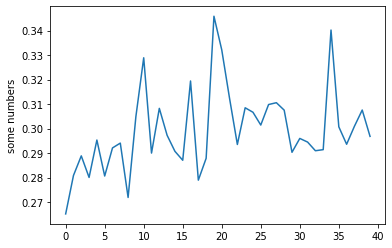

In [0]:
maps
a = np.array(maps)
plt.figure(0)
plt.plot(a[:,0])
plt.ylabel('some numbers')
plt.show()

In [0]:
print(train_gt.classes)

['person']


YOLO
----

In [0]:
from collections import defaultdict
from gluoncv.utils import bbox_iou
class RepulsionLoss(gluon.Block):
  def __init__(self, iou_thresh = 0.5, sigma = 0.5, epo = 0.1, **kwargs):
    super(RepulsionLoss, self).__init__(**kwargs)
    self.iou_thresh = iou_thresh
    self.sigma = sigma
    self.epo = epo
  def Smooth_Ln(self, x, sigma):
    large = np.where(x > sigma)
    small = np.where(x <= sigma)

    large = x[large]
    small = x[small]

    large = np.sum((large-sigma)/(1-sigma) - np.log(1-sigma))
    small = np.sum(-np.log(1-small))

    return (large + small)
  def forward(self, cls_preds, box_preds, cls_targets, box_targets, loss = None):
    RepLoss = []
    all_box_gt = box_targets[0].asnumpy()
    all_box_pred = box_preds[0].asnumpy()
    # print(all_box_gt.shape, box_pred.shape)
    for i in range(all_box_pred.shape[0]):
      #filter out all zero rows(mainly gt)
      nonzero_boxgt_index = np.where(all_box_gt[i][:,0] != all_box_gt[i][:,2])
      nonzero_boxpred_index = np.where(all_box_pred[i][:,0] != all_box_pred[i][:,2])

      nonzero_box_gt = all_box_gt[i][nonzero_boxgt_index][:,0:4]
      nonzero_box_pred = all_box_pred[i][nonzero_boxpred_index][:,0:4]

      #calculate iou
      _iou = bbox_iou(nonzero_box_pred, nonzero_box_gt)

      # select positive proposals
      pos_index = np.where(np.max(_iou, axis=1) >= self.iou_thresh)
      _iou = _iou[pos_index]
      # print('iou shape ', _iou.shape)
      #for each positive proposals keep its top two iou with targets
      sort_index = _iou.argsort(axis = 1)[:,-2:]
      iog = []
      for _i in range(len(sort_index)):
        tmp = _iou[_i, sort_index[_i]]
        iog.append(tmp)
      iog = np.array(iog)
      # print('iog first and second',iog.shape)
      # print()
      if iog.shape[0] == 0:
        RepGT = 0
        RepBo = 0
      else:
        #RepulsionGT
        RepGT = self.Smooth_Ln(iog[:,0], self.sigma)/iog.shape[0]
        #for each ground truth keep only the proposal with highest iou
        pos_gt_prop_index = np.argmax(_iou, axis=0)
        pos_gt_prop = np.array([nonzero_box_pred[pos_gt_prop_index], nonzero_box_pred[pos_gt_prop_index]])
        # RepulsionBox
        box_l = np.array([])
        total_iou = np.array([])
        for row in range(len(pos_gt_prop[0])-1):
          curr = pos_gt_prop[0][row].reshape(1,-1)
          rest = pos_gt_prop[1][row+1:]
          _bbox_iou = bbox_iou(curr, rest)
          box_l = np.hstack((box_l, [self.Smooth_Ln(_bbox_iou, self.sigma)]))
          total_iou = np.hstack((total_iou, [np.sum(_bbox_iou)]))
        RepBo = np.sum(box_l) / (np.sum(total_iou) + self.epo)
          # print('loss',Smooth_Ln(_bbox_iou, sigma), RepBo)
      RepLoss.append(RepGT + RepBo)
    RepLoss = [nd.array(RepLoss, ctx=mx.gpu(0))]
    if loss:
      sum_loss, cls_loss, box_loss = loss(cls_preds, box_preds, cls_targets, box_targets)#TODO:YOLO-VERSION
      return nd.add(RepLoss[0], sum_loss[0]), cls_loss, box_loss
    else:
      return RepLoss, 0,0

In [0]:
def get_dataloader(net, train_dataset, val_dataset, width, height, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.yolo import YOLO3DefaultTrainTransform, YOLO3DefaultValTransform

    # use fake data to generate fixed anchors for target generation    
    train_batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))  # stack image, all targets generated
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(YOLO3DefaultTrainTransform(width, height, net)),
        batch_size, True, batchify_fn=train_batchify_fn, last_batch='rollover', num_workers=num_workers)
    
    val__batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
    val_loader = gluon.data.DataLoader(
        val_dataset.transform(YOLO3DefaultValTransform(width, height)),
        batch_size, True, batchify_fn=val__batchify_fn, last_batch='rollover', num_workers=num_workers) 
    
    return train_loader, val_loader

train_loader, val_loader = get_dataloader(net, train_lst_dataset, val_lst_dataset,  640, 480, 6, 0)

In [0]:
from gluoncv.utils.metrics.voc_detection import VOC07MApMetric
def validate(net, val_data, ctx, eval_metric):
    """Test on validation dataset."""
    eval_metric.reset()
    # set nms threshold and topk constraint
    net.set_nms(nms_thresh=0.45, nms_topk=400)
    net.hybridize(static_alloc=True, static_shape=True)
    for batch in val_data:
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        det_bboxes = []
        det_ids = []
        det_scores = []
        gt_bboxes = []
        gt_ids = []
        gt_difficults = []
        for x, y in zip(data, label):
            # get prediction results
            ids, scores, bboxes = net(x)
            det_ids.append(ids)
            det_scores.append(scores)
            # clip to image size
            det_bboxes.append(bboxes.clip(0, batch[0].shape[2]))
            # split ground truths
            gt_ids.append(y.slice_axis(axis=-1, begin=4, end=5))
            gt_bboxes.append(y.slice_axis(axis=-1, begin=0, end=4))
            gt_difficults.append(y.slice_axis(axis=-1, begin=5, end=6) if y.shape[-1] > 5 else None)

        # update metric
        eval_metric.update(det_bboxes, det_ids, det_scores, gt_bboxes, gt_ids, gt_difficults)
    return eval_metric.get()
eval_metric = VOC07MApMetric(iou_thresh=0.5, class_names=val_gt.classes)

In [0]:
def train(net, train_loader, val_loader, eval_metric, ctx, epochs = 10, save_path = './', optimizer_parameter = {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9}, seed = 0):
    utils.random.seed(seed)
    net.collect_params().reset_ctx(ctx)
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': optimizer_parameter['learning_rate'], 'wd': optimizer_parameter['wd'], 'momentum': optimizer_parameter['momentum']})

    mbox_loss = gcv.loss.SSDMultiBoxLoss(lambd = 0.5)
    Repulsion = RepulsionLoss()#gcv.loss.SSDMultiBoxLoss()
    obj_metrics = mx.metric.Loss('ObjLoss')
    center_metrics = mx.metric.Loss('BoxCenterLoss')
    scale_metrics = mx.metric.Loss('BoxScaleLoss')
    cls_metrics = mx.metric.Loss('ClassLoss')

    best_mean_ap = float('-inf')
    for epoch in range(epochs):
        obj_metrics.reset()
        center_metrics.reset()
        scale_metrics.reset()
        cls_metrics.reset()

        tic = time.time()
        btic = time.time()

        # print(epochs, optimizer_parameter['lr_decay_step'], epoch % optimizer_parameter['lr_decay_step'] == 0)
        if 'lr_decay' in optimizer_parameter and 'lr_decay_step' in optimizer_parameter\
        and epoch != 0 and epoch % optimizer_parameter['lr_decay_step'] == 0:
            old_lr = trainer.learning_rate
            new_lr = trainer.learning_rate * optimizer_parameter['lr_decay']
            trainer.set_learning_rate(new_lr)
            print(f'The learning rate from {old_lr} change to {new_lr}')


        net.hybridize(static_alloc=True, static_shape=True)
        qbar = tqdm(train_loader)
        qbar.desc = f'Epoch {epoch + 1}'
        for i, batch in enumerate(qbar):
            batch_size = batch[0].shape[0]
            data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
            # objectness, center_targets, scale_targets, weights, class_targets
            fixed_targets = [gluon.utils.split_and_load(batch[it], ctx_list=ctx, batch_axis=0) for it in range(1, 6)]
            gt_boxes = gluon.utils.split_and_load(batch[6], ctx_list=ctx, batch_axis=0)
            cls_target = gluon.utils.split_and_load(batch[5], ctx_list=ctx, batch_axis=0)
            sum_losses = []
            obj_losses = []
            center_losses = []
            scale_losses = []
            cls_losses = []
            with autograd.record():
                for ix, x in enumerate(data):
                    obj_loss, center_loss, scale_loss, cls_loss = net(x, gt_boxes[ix], *[ft[ix] for ft in fixed_targets])
                    sum_losses.append(obj_loss + center_loss + scale_loss + cls_loss)
                    obj_losses.append(obj_loss)
                    center_losses.append(center_loss)
                    scale_losses.append(scale_loss)
                    cls_losses.append(cls_loss)
                autograd.backward(sum_losses)
            # since we have already normalized the loss, we don't want to normalize
            # by batch-size anymore
            trainer.step(batch_size)
            obj_metrics.update(0, obj_losses)
            center_metrics.update(0, center_losses)
            scale_metrics.update(0, scale_losses)
            cls_metrics.update(0, cls_losses)
            name1, loss1 = obj_metrics.get()
            name2, loss2 = center_metrics.get()
            name3, loss3 = scale_metrics.get()
            name4, loss4 = cls_metrics.get()
            qbar.set_postfix({'Batch': i, name1: loss1, name2: loss2, name3: loss3, name4: loss4})
            btic = time.time()
        map_name, mean_ap = validate(net, val_loader, ctx, eval_metric)
        print(f'{map_name}: {mean_ap}')
        if best_mean_ap <= mean_ap[-1]:
            net.save_parameters(f'yolo_best_{epoch}.params')
            best_mean_ap = mean_ap[-1]

optimizer_parameter = {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9, 'lr_decay': 0.5, 'lr_decay_step': 4}
train(net, train_loader, val_loader, eval_metric, ctx = ctx, optimizer_parameter = optimizer_parameter, epochs = 40)

Epoch 1:   6%|▋         | 16/251 [01:10<14:14,  3.64s/it, Batch=15, ObjLoss=23.4, BoxCenterLoss=8.75, BoxScaleLoss=4.23, ClassLoss=0.856]

KeyboardInterrupt: ignored

In [0]:
[[0.36627248815012564, 0.36627248815012564],
 [0.4459416998932896, 0.4459416998932896],
 [0.46637687680113415, 0.46637687680113415],
 [0.524909435722302, 0.524909435722302],
 [0.6044008314099509, 0.6044008314099509],
 [0.6281412134118801, 0.6281412134118801],
 [0.646725797753222, 0.646725797753222],
 [0.6527360891605642, 0.6527360891605642],
 [0.6942240836373811, 0.6942240836373811],
 [0.7089228233940059, 0.7089228233940059],
 [0.7098197517485075, 0.7098197517485075],
 [0.7497823796978532, 0.7497823796978532],
[0.7777757884934859, 0.7777757884934859],
 [0.7864073453566716, 0.7864073453566716],
 [0.7855302297966658, 0.7855302297966658],
 [0.7857642691394656, 0.7857642691394656],
 [0.799987148042133, 0.799987148042133],
 [0.8154502637700861, 0.8154502637700861],
 [0.8112674938809562, 0.8112674938809562],
 [0.8223701093131629, 0.8223701093131629],
 [0.8256986181635348, 0.8256986181635348],
 [0.8294586636823578, 0.8294586636823578],
 [0.8323488639936151, 0.8323488639936151],
 [0.8345390093769928, 0.8345390093769928],
 [0.8398620907711277, 0.8398620907711277],
 [0.8352644739365551, 0.8352644739365551],
 [0.840788772717012, 0.840788772717012],
 [0.8431784965155965, 0.8431784965155965],
 [0.8420016373898731, 0.8420016373898731],
 [0.8450661478122047, 0.8450661478122047],
 [0.8443205875287926, 0.8443205875287926],
 [0.8455156957882689, 0.8455156957882689],
 [0.8460566429088425, 0.8460566429088425],
 [0.8476423780413903, 0.8476423780413903],
 [0.8462805931672585, 0.8462805931672585],
 [0.8470091348901788, 0.8470091348901788],
 [0.8478945557207828, 0.8478945557207828],
 [0.8476759219061685, 0.8476759219061685],
 [0.8493012266899288, 0.8493012266899288],
 [0.8491161146823408, 0.8491161146823408]]

In [0]:
!nvidia-smi

Predict with finetuned model
----------------------------
We can test the performance using finetuned weights



In [0]:
ls ./ValImages

In [0]:
net = gcv.model_zoo.get_model('ssd_512_resnet50_v1_custom', classes=train_gt.classes, pretrained_base=False)
net.load_parameters('ssd_best.params')
x, image = gcv.data.transforms.presets.ssd.load_test('./ValImages/3526.png', 512)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=val_gt.classes)
plt.show()

In two epochs and less than 5 min, we are able to detect pikachus perfectly!

.. hint::

    This finetune tutorial is not limited to SSD, you can extend it to Faster-RCNN, YOLO training by
    adapting a training blocks in the following examples:

    :download:`Download train_faster_rcnn.py<../../../scripts/detection/faster_rcnn/train_faster_rcnn.py>`
    :download:`Download train_yolo3.py<../../../scripts/detection/yolo/train_yolo3.py>`

